# For Image

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage
import math
import time
from math import log10, sqrt 

import imageio
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("numpy version : {}".format(np.__version__))
print("tensorflow version : {}".format(tf.__version__))

numpy version : 1.21.0
tensorflow version : 2.5.0


### Prepareing Data

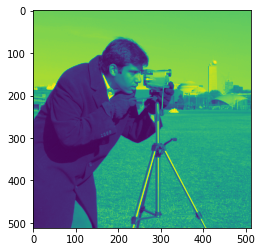

In [3]:
Image = skimage.data.camera()
#Image = plt.imread("8.png")
#Image = plt.imread("CT.jpg") / 255.
plt.imshow(Image)

In [4]:
#def rgb2gray(rgb):
#    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])
#  
#Image = rgb2gray(Image)   

In [5]:
# for "1.jpg" image
#Image = plt.imread("1.jpg")
#c = [Image.shape[0]//2, Image.shape[1]//2]
#r = 256
#Image = Image[c[0]-r:c[0]+r, c[1]-r:c[1]+r]
#Image = Image[::2,::2] / 255.
#plt.imshow(Image)

In [6]:
Image = Image.astype(np.float32)
#Image = Image.astype(np.float32)[:256, :256, :]
#Image = Image.astype(np.float32)[:512, :512, :]

In [7]:
Image = Image / 255

In [8]:
def make_coordiante(shape):
    x_coordinates = np.linspace(-1, +1, shape[0])
    y_coordinates = np.linspace(-1, +1, shape[1])
    x_coordinates, y_coordinates = np.meshgrid(x_coordinates, y_coordinates)
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()
    Coordinates = np.stack([x_coordinates, y_coordinates]).T
    return Coordinates

In [9]:
Coordinates = make_coordiante(Image.shape)

In [10]:
RGB_values = Image.flatten()
#RGB_values = np.array([Image[:,:,color].flatten() for color in range(3)]).T

In [11]:
n_fourier_features = 10
scale = 10

B = np.random.randn(2, n_fourier_features)
B = scale * B

Coordinates = Coordinates @ B
Coordinates = np.concatenate([np.sin(2 * math.pi * Coordinates), np.cos(2 * math.pi * Coordinates)], axis=-1)
Coordinates.shape

(262144, 20)

In [12]:
## for Test tile input
#Coordinates = np.tile(Coordinates, (1, 128))

In [13]:
#RGB_mean = RGB_values.mean(axis=0)
#RGB_std = RGB_values.std(axis=0)

#RGB_values = (RGB_values - RGB_mean) / (RGB_std)

### Build Model

#### RBF Layer

In [14]:
class RBFLayer(tf.keras.layers.Layer):
    '''Transforms incoming data using a given radial basis function.
        - Input: (1, N, in_features) where N is an arbitrary batch size
        - Output: (1, N, out_features) where N is an arbitrary batch size'''

    def __init__(self, in_features, out_features):
        super(RBFLayer, self).__init__()
        self.in_features = in_features
        self.out_features = out_features



    def build(self, input_shape):
        self.centres = self.add_weight(
            name='centres',
            shape=(self.out_features, self.in_features),
            initializer=tf.keras.initializers.RandomUniform(minval=-1, maxval=1),
            trainable=True)
        
        self.sigmas = self.add_weight(
            name='sigmas',
            shape=(self.out_features,),
            initializer=tf.keras.initializers.Constant(10),
            trainable=True)
        

        #self.freq = self.add_weight(
        #    name='freq',
        #    shape=(1, self.out_features),
        #    initializer=tf.keras.initializers.Constant(np.pi),
        #    trainable=True)
        super(RBFLayer, self).build(input_shape)


    def call(self, input):
        size = (input.shape[0], self.out_features, self.in_features)  

        x = tf.expand_dims(input, axis=1)
        x = tf.tile(x, (1, self.out_features, 1))

        c = tf.expand_dims(self.centres, axis=0)
        c = tf.tile(c, (input.shape[0], 1, 1))

        distances = tf.reduce_sum((x - c) ** 2, axis=-1) * tf.expand_dims(self.sigmas, axis=0)

        return self.gaussian(distances)
      
    def gaussian(self, alpha):
        phi = tf.exp(-1 * alpha ** 2)
        return phi

#### Sine Layer

In [15]:
class SineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(SineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)

    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = tf.sin(self.omega_0 * befor_activation)
        #after_activation = befor_activation
        return after_activation

In [16]:
class SineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(SineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / self.in_features,
                                                       maxval= 1 / self.in_features)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = tf.sin(self.omega_0 * befor_activation)
        #after_activation = befor_activation
        return after_activation

#### Parametric

In [17]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    

    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)

    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
            
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
        
        #else:
        #    return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit() * self.omega_0),
        #                                               maxval= 1 / (self.cal_limit() * self.omega_0))
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w0 = self.add_weight(
            name='w0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift0 = self.add_weight(
            name='shift0',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift1 = self.add_weight(
            name='shift1',
            shape=(1,),
            initializer='zeros',
            trainable=True)


        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * self.omega_0 * befor_activation + \
                           self.a0 * tf.sin(self.w0 * self.omega_0 * befor_activation + self.shift0) + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation + self.shift1)
        return after_activation

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [18]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    
    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / self.in_features,
                                                       maxval= 1 / self.in_features)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w0 = self.add_weight(
            name='w0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift0 = self.add_weight(
            name='shift0',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift1 = self.add_weight(
            name='shift1',
            shape=(1,),
            initializer='zeros',
            trainable=True)


        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * self.omega_0 * befor_activation + \
                           self.a0 * tf.sin(self.w0 * self.omega_0 * befor_activation + self.shift0) + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation + self.shift1)
        return after_activation

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [19]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    

    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)

    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
            
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
        
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)


        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w0 = self.add_weight(
            name='w0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift0 = self.add_weight(
            name='shift0',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift1 = self.add_weight(
            name='shift1',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        


        self.a2 = self.add_weight(
            name='a2',
            shape=(1,),
            initializer=tf.keras.initializers.constant(1/20.),
            trainable=True)
        self.w2 = self.add_weight(
            name='w2',
            shape=(1,),
            initializer=tf.keras.initializers.constant(2.),
            trainable=True)
        self.shift2 = self.add_weight(
            name='shift2',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a3 = self.add_weight(
            name='a3',
            shape=(1,),
            initializer=tf.keras.initializers.constant(0.),
            trainable=True)
        self.w3 = self.add_weight(
            name='w3',
            shape=(1,),
            initializer=tf.keras.initializers.constant(2.),
            trainable=True)
        self.shift3 = self.add_weight(
            name='shift3',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        


        self.a4 = self.add_weight(
            name='a4',
            shape=(1,),
            initializer=tf.keras.initializers.constant(0.),
            trainable=True)
        self.w4 = self.add_weight(
            name='w4',
            shape=(1,),
            initializer=tf.keras.initializers.constant(3.),
            trainable=True)
        self.shift4 = self.add_weight(
            name='shift4',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a5 = self.add_weight(
            name='a5',
            shape=(1,),
            initializer=tf.keras.initializers.constant(1/30.),
            trainable=True)
        self.w5 = self.add_weight(
            name='w5',
            shape=(1,),
            initializer=tf.keras.initializers.constant(3.),
            trainable=True)
        self.shift5 = self.add_weight(
            name='shift5',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        

        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * self.omega_0 * befor_activation + \
                           self.a0 * tf.sin(self.w0 * self.omega_0 * befor_activation + self.shift0) + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation + self.shift1) + \
                           self.a2 * tf.sin(self.w2 * self.omega_0 * befor_activation + self.shift2) + \
                           self.a3 * tf.cos(self.w3 * self.omega_0 * befor_activation + self.shift3) + \
                           self.a4 * tf.sin(self.w4 * self.omega_0 * befor_activation + self.shift4) + \
                           self.a5 * tf.cos(self.w5 * self.omega_0 * befor_activation + self.shift5)
        return after_activation

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

#### SIREN

In [20]:
class Siren(tf.keras.Model):
    def __init__(self, in_features,
                    units,
                    out_features,
                    outermost_linear=True,
                    first_omega_0=30.,
                    hidden_omega_0=30.):
        super(Siren, self).__init__()
        self.in_features = in_features
        self.units = units
        self.out_features = out_features
        self.outermost_linear = outermost_linear
        self.first_omega_0 = first_omega_0
        self.hidden_omega_0 = hidden_omega_0


        self.net = []

        self.net.append(SineLayer(self.in_features,
                                  self.units[0],
                                  is_first=True,
                                  omega_0=self.first_omega_0))

        for counter in range(1, len(units)):
            self.net.append(SineLayer(self.units[counter-1],
                                      self.units[counter], 
                                      is_first=False,
                                      omega_0=self.hidden_omega_0))

        if self.outermost_linear:
            self.net.append(tf.keras.layers.Dense(self.out_features,
                                                  kernel_initializer=self.init_weights()))
        else:
            self.net.append(SineLayer(self.units[counter],
                                      self.out_features,
                                      is_first=False,
                                      omega_0=self.hidden_omega_0))


    def init_weights(self):
        return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.units[-1]) / self.hidden_omega_0,
                                                   maxval= np.sqrt(6. / self.units[-1]) / self.hidden_omega_0)



    def call(self, input_tensor):
        x = input_tensor
        for layer in self.net:
            x = layer(x)
        
        return x

In [21]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

In [30]:
tf.keras.backend.clear_session()




step_show = 1
batch_size = 16 * 1024

if len(Image.shape) == 3:
   output_channel = 3
else:
   output_channel = 1


n_fourier_features = 10
scale = 10

B = np.random.randn(2, n_fourier_features)
B = scale * B



class CustomSaver(tf.keras.callbacks.Callback):
    def __init__(self, image_shape, is_fourier=False):
        super(CustomSaver, self).__init__()
        self.image_shape = image_shape

        self.data = make_coordiante(self.image_shape)
        if is_fourier:
          self.data = self.data @ B
          self.data = np.concatenate([np.sin(2 * math.pi * self.data), np.cos(2 * math.pi * self.data)], axis=-1)
          self.data = tf.data.Dataset.from_tensor_slices(self.data).batch(batch_size)
        else:
          self.data = tf.data.Dataset.from_tensor_slices(self.data).batch(batch_size)
        self.images = []
    def on_epoch_end(self, epoch, logs={}):
        if epoch % step_show == 0:
           self.images.append(self.model.predict(self.data).reshape(self.image_shape))

save_result_siren = CustomSaver(Image.shape)
save_result_param = CustomSaver(Image.shape)
save_result_relu = CustomSaver(Image.shape)
save_result_fourier = CustomSaver(Image.shape, is_fourier=True)

In [31]:
omega_0 = 30
hidden_units = 256

hidden_initializers = tf.keras.initializers.RandomUniform(minval=-np.sqrt(6/hidden_units)/omega_0, maxval=np.sqrt(6/hidden_units)/omega_0)

In [32]:
## SIREN Model
X = tf.keras.layers.Input(shape=(2,))
x1 = SineLayer(2, hidden_units, is_first=True, omega_0=30)(X)
x2 = SineLayer(hidden_units, hidden_units, is_first=False)(x1)
x3 = SineLayer(hidden_units, hidden_units, is_first=False)(x2)
x4 = SineLayer(hidden_units, hidden_units, is_first=False)(x3)

x = tf.keras.layers.Add()([x1, x2, x3, x4])

Y = tf.keras.layers.Dense(output_channel, kernel_initializer=hidden_initializers)(x)

siren_model = tf.keras.models.Model(X, Y)

In [33]:
## Parametric Model
X = tf.keras.layers.Input(shape=(2,))
x1 = ParaSineLayer(2, hidden_units, is_first=True, omega_0=30)(X)
x2 = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x1)
x3 = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x2)
x4 = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x3)

x = tf.keras.layers.Add()([x1, x2, x3, x4])

Y = tf.keras.layers.Dense(output_channel, kernel_initializer=hidden_initializers)(x)

parametric_model = tf.keras.models.Model(X, Y)

In [34]:
## Fourier Model
X = tf.keras.layers.Input(shape=(2 * n_fourier_features,))
x1 = tf.keras.layers.Dense(hidden_units, activation='relu')(X)
x2 = tf.keras.layers.Dense(hidden_units, activation='relu')(x1)
x3 = tf.keras.layers.Dense(hidden_units, activation='relu')(x2)
x4 = tf.keras.layers.Dense(hidden_units, activation='relu')(x3)

x = tf.keras.layers.Add()([x1, x2, x3, x4])

Y = tf.keras.layers.Dense(output_channel)(x)

fourier_model = tf.keras.models.Model(X, Y)

In [35]:
## Relu Model
X = tf.keras.layers.Input(shape=(2,))
x1 = tf.keras.layers.Dense(hidden_units, activation='relu')(X)
x2 = tf.keras.layers.Dense(hidden_units, activation='relu')(x1)
x3 = tf.keras.layers.Dense(hidden_units, activation='relu')(x2)
x4 = tf.keras.layers.Dense(hidden_units, activation='relu')(x3)

x = tf.keras.layers.Add()([x1, x2, x3, x4])

Y = tf.keras.layers.Dense(output_channel)(x)

relu_model = tf.keras.models.Model(X, Y)

In [36]:
siren_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2)]          0                                            
__________________________________________________________________________________________________
sine_layer (SineLayer)          (None, 256)          768         input_1[0][0]                    
__________________________________________________________________________________________________
sine_layer_1 (SineLayer)        (None, 256)          65792       sine_layer[0][0]                 
__________________________________________________________________________________________________
sine_layer_2 (SineLayer)        (None, 256)          65792       sine_layer_1[0][0]               
______________________________________________________________________________________________

In [37]:
def scheduler(epoch, lr):
  if epoch < 100:
    return lr
  else:
    if epoch % 100 == 0:
        lr = lr * tf.math.exp(-0.05)
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
models = [relu_model,
          fourier_model,
          siren_model,
          parametric_model]

callbacks = [save_result_relu,
             save_result_fourier,
             save_result_siren,
             save_result_param]

model_name = [
              "Relu",
              "Fourier Feature",
              "Siren",
              "Parametric"
]

with_fourier = [False,
                True,
                False,
                False]


History = []

epochs = 15000
for counter in range(len(models)):

    Coordinates = make_coordiante(Image.shape)
    if with_fourier[counter]:
       Coordinates = Coordinates @ B
       Coordinates = np.concatenate([np.sin(2 * math.pi * Coordinates), np.cos(2 * math.pi * Coordinates)], axis=-1)
    
    dataset = tf.data.Dataset.from_tensor_slices((Coordinates, RGB_values))
    dataset = dataset.shuffle(len(Coordinates)).batch(batch_size)

    optimizer = tf.keras.optimizers.Adam(1e-4)
    loss = tf.keras.losses.MeanSquaredError() 

    models[counter].compile(optimizer=optimizer, loss=loss)

    print(20*"*", model_name[counter], 20*"*")
    history = models[counter].fit(dataset, epochs=epochs, callbacks=[callback, callbacks[counter]])
    History.append(history.history['loss'])

 8/16 [==============>...............] - ETA: 0s - loss: 0.0414

 9/16 [===============>..............] - ETA: 0s - loss: 0.0413

10/16 [=================>............] - ETA: 0s - loss: 0.0412

11/16 [===================>..........] - ETA: 0s - loss: 0.0410

12/16 [=====================>........] - ETA: 0s - loss: 0.0409

13/16 [=======================>......] - ETA: 0s - loss: 0.0408

14/16 [=========================>....] - ETA: 0s - loss: 0.0407

15/16 [===========================>..] - ETA: 0s - loss: 0.0406

16/16 [==============================] - ETA: 0s - loss: 0.0405

16/16 [==============================] - 1s 81ms/step - loss: 0.0405


Epoch 5/15000


 1/16 [>.............................] - ETA: 4s - loss: 0.0390

 2/16 [==>...........................] - ETA: 1s - loss: 0.0390

 3/16 [====>.........................] - ETA: 1s - loss: 0.0388

 4/16 [======>.......................] - ETA: 0s - loss: 0.0386

 5/16 [========>.....................] - ETA: 0s - loss: 0.0385

 6/16 [==========>...................] - ETA: 0s - loss: 0.0385

 7/16 [============>.................] - ETA: 0s - loss: 0.0383

 8/16 [==============>...............] - ETA: 0s - loss: 0.0383

 9/16 [===============>..............] - ETA: 0s - loss: 0.0383

10/16 [=================>............] - ETA: 0s - loss: 0.0382

11/16 [===================>..........] - ETA: 0s - loss: 0.0382

12/16 [=====================>........] - ETA: 0s - loss: 0.0381

13/16 [=======================>......] - ETA: 0s - loss: 0.0380

14/16 [=========================>....] - ETA: 0s - loss: 0.0380

15/16 [===========================>..] - ETA: 0s - loss: 0.0379

16/16 [==============================] - ETA: 0s - loss: 0.0379

16/16 [==============================] - 2s 84ms/step - loss: 0.0379


Epoch 6/15000


 1/16 [>.............................] - ETA: 3s - loss: 0.0371

 2/16 [==>...........................] - ETA: 1s - loss: 0.0370

 3/16 [====>.........................] - ETA: 1s - loss: 0.0369

 4/16 [======>.......................] - ETA: 1s - loss: 0.0368

 5/16 [========>.....................] - ETA: 0s - loss: 0.0369

 6/16 [==========>...................] - ETA: 0s - loss: 0.0367

 7/16 [============>.................] - ETA: 0s - loss: 0.0367

 8/16 [==============>...............] - ETA: 0s - loss: 0.0366

 9/16 [===============>..............] - ETA: 0s - loss: 0.0366

10/16 [=================>............] - ETA: 0s - loss: 0.0366

11/16 [===================>..........] - ETA: 0s - loss: 0.0365

12/16 [=====================>........] - ETA: 0s - loss: 0.0364

13/16 [=======================>......] - ETA: 0s - loss: 0.0364

14/16 [=========================>....] - ETA: 0s - loss: 0.0363

15/16 [===========================>..] - ETA: 0s - loss: 0.0363

16/16 [==============================] - ETA: 0s - loss: 0.0363

16/16 [==============================] - 2s 83ms/step - loss: 0.0363


Epoch 7/15000


 1/16 [>.............................] - ETA: 3s - loss: 0.0352

 2/16 [==>...........................] - ETA: 1s - loss: 0.0354

 3/16 [====>.........................] - ETA: 1s - loss: 0.0357

 4/16 [======>.......................] - ETA: 0s - loss: 0.0356

 5/16 [========>.....................] - ETA: 0s - loss: 0.0356

 6/16 [==========>...................] - ETA: 0s - loss: 0.0356

 7/16 [============>.................] - ETA: 0s - loss: 0.0356

 8/16 [==============>...............] - ETA: 0s - loss: 0.0355

 9/16 [===============>..............] - ETA: 0s - loss: 0.0354

10/16 [=================>............] - ETA: 0s - loss: 0.0353

11/16 [===================>..........] - ETA: 0s - loss: 0.0353

12/16 [=====================>........] - ETA: 0s - loss: 0.0353

13/16 [=======================>......] - ETA: 0s - loss: 0.0352

14/16 [=========================>....] - ETA: 0s - loss: 0.0352

15/16 [===========================>..] - ETA: 0s - loss: 0.0351

16/16 [==============================] - ETA: 0s - loss: 0.0351

16/16 [==============================] - 1s 79ms/step - loss: 0.0351


Epoch 8/15000


 1/16 [>.............................] - ETA: 3s - loss: 0.0346

 2/16 [==>...........................] - ETA: 1s - loss: 0.0343

 3/16 [====>.........................] - ETA: 1s - loss: 0.0343

 4/16 [======>.......................] - ETA: 0s - loss: 0.0344

 5/16 [========>.....................] - ETA: 0s - loss: 0.0343

 6/16 [==========>...................] - ETA: 0s - loss: 0.0342

 7/16 [============>.................] - ETA: 0s - loss: 0.0342

 8/16 [==============>...............] - ETA: 0s - loss: 0.0342

 9/16 [===============>..............] - ETA: 0s - loss: 0.0341

10/16 [=================>............] - ETA: 0s - loss: 0.0341

11/16 [===================>..........] - ETA: 0s - loss: 0.0341

12/16 [=====================>........] - ETA: 0s - loss: 0.0342

13/16 [=======================>......] - ETA: 0s - loss: 0.0341

14/16 [=========================>....] - ETA: 0s - loss: 0.0341

15/16 [===========================>..] - ETA: 0s - loss: 0.0340

16/16 [==============================] - ETA: 0s - loss: 0.0340

16/16 [==============================] - 1s 80ms/step - loss: 0.0340


Epoch 9/15000


 1/16 [>.............................] - ETA: 3s - loss: 0.0337

 2/16 [==>...........................] - ETA: 1s - loss: 0.0334

 3/16 [====>.........................] - ETA: 1s - loss: 0.0331

 4/16 [======>.......................] - ETA: 0s - loss: 0.0333

 5/16 [========>.....................] - ETA: 0s - loss: 0.0334

 6/16 [==========>...................] - ETA: 0s - loss: 0.0333

 7/16 [============>.................] - ETA: 0s - loss: 0.0333

 8/16 [==============>...............] - ETA: 0s - loss: 0.0332

 9/16 [===============>..............] - ETA: 0s - loss: 0.0331

10/16 [=================>............] - ETA: 0s - loss: 0.0331

11/16 [===================>..........] - ETA: 0s - loss: 0.0331

12/16 [=====================>........] - ETA: 0s - loss: 0.0331

13/16 [=======================>......] - ETA: 0s - loss: 0.0331

14/16 [=========================>....] - ETA: 0s - loss: 0.0330

15/16 [===========================>..] - ETA: 0s - loss: 0.0330

16/16 [==============================] - ETA: 0s - loss: 0.0330

16/16 [==============================] - 1s 80ms/step - loss: 0.0330


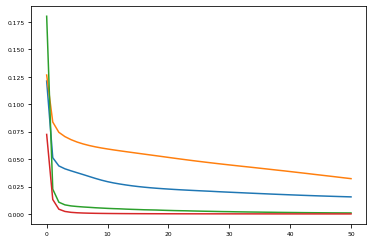

In [158]:
plt.plot(np.stack(History).T)

In [159]:
Video = []
#model_psnr = []
for save_result in callbacks:
  Video.append(np.stack(save_result.images))
  #psnr_buff = []
  #for image in save_result.images:
  #    psnr_buff.append(PSNR(Image, image))
  #model_psnr.append(psnr_buff)

#model_psnr = np.stack(model_psnr)
Video = np.concatenate(Video, axis=2)


model_psnr = 20 * np.log10(1.0 / np.sqrt(np.stack(History).T)).T

In [161]:
if output_channel == 3: 
   images_gt = np.tile(np.expand_dims(Image, axis=0), (int(epochs / step_show) + 1, 1, 1, 1))
else:
   images_gt = np.tile(np.expand_dims(Image, axis=0), (int(epochs / step_show) + 1, 1, 1))
Video = np.concatenate([images_gt, Video], axis=2)   
Video = (255 * np.clip(Video, 0, 1)).astype(np.uint8)
f = os.path.join('training_convergence.mp4')
imageio.mimwrite(f, Video, fps=3)

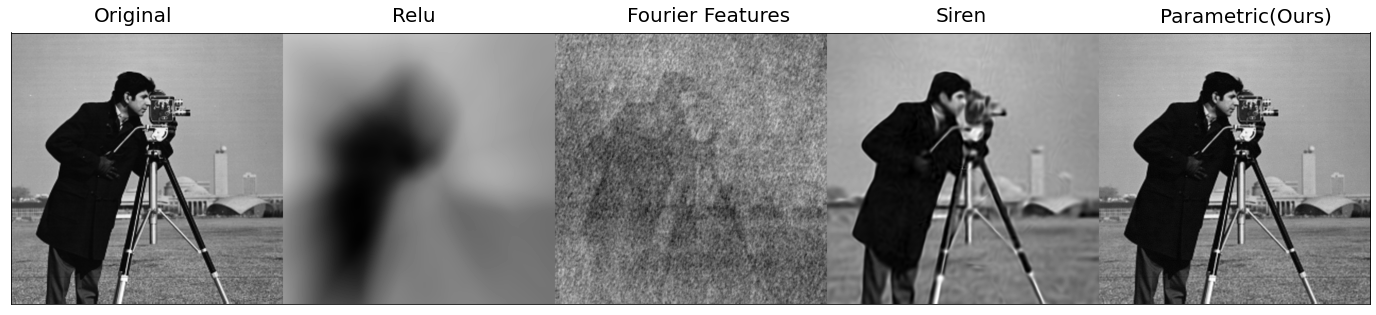

In [162]:
text_font = {'fontname':'Arial', 'size':'20'}

plt.figure(figsize=(25, 5))
plt.imshow(Video[3], cmap='gray')
plt.xticks([])
plt.yticks([])
plt.text(1 * 256 - 100, -20, 'Original', **text_font)
plt.text(3 * 256 - 50 , -20, 'Relu', **text_font)
plt.text(5 * 256 - 120, -20, 'Fourier Features', **text_font)
plt.text(7 * 256 - 50 , -20, 'Siren', **text_font)
plt.text(9 * 256 - 140, -20, 'Parametric(Ours)', **text_font)

plt.savefig('Compresion_on_Epoch20.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0)

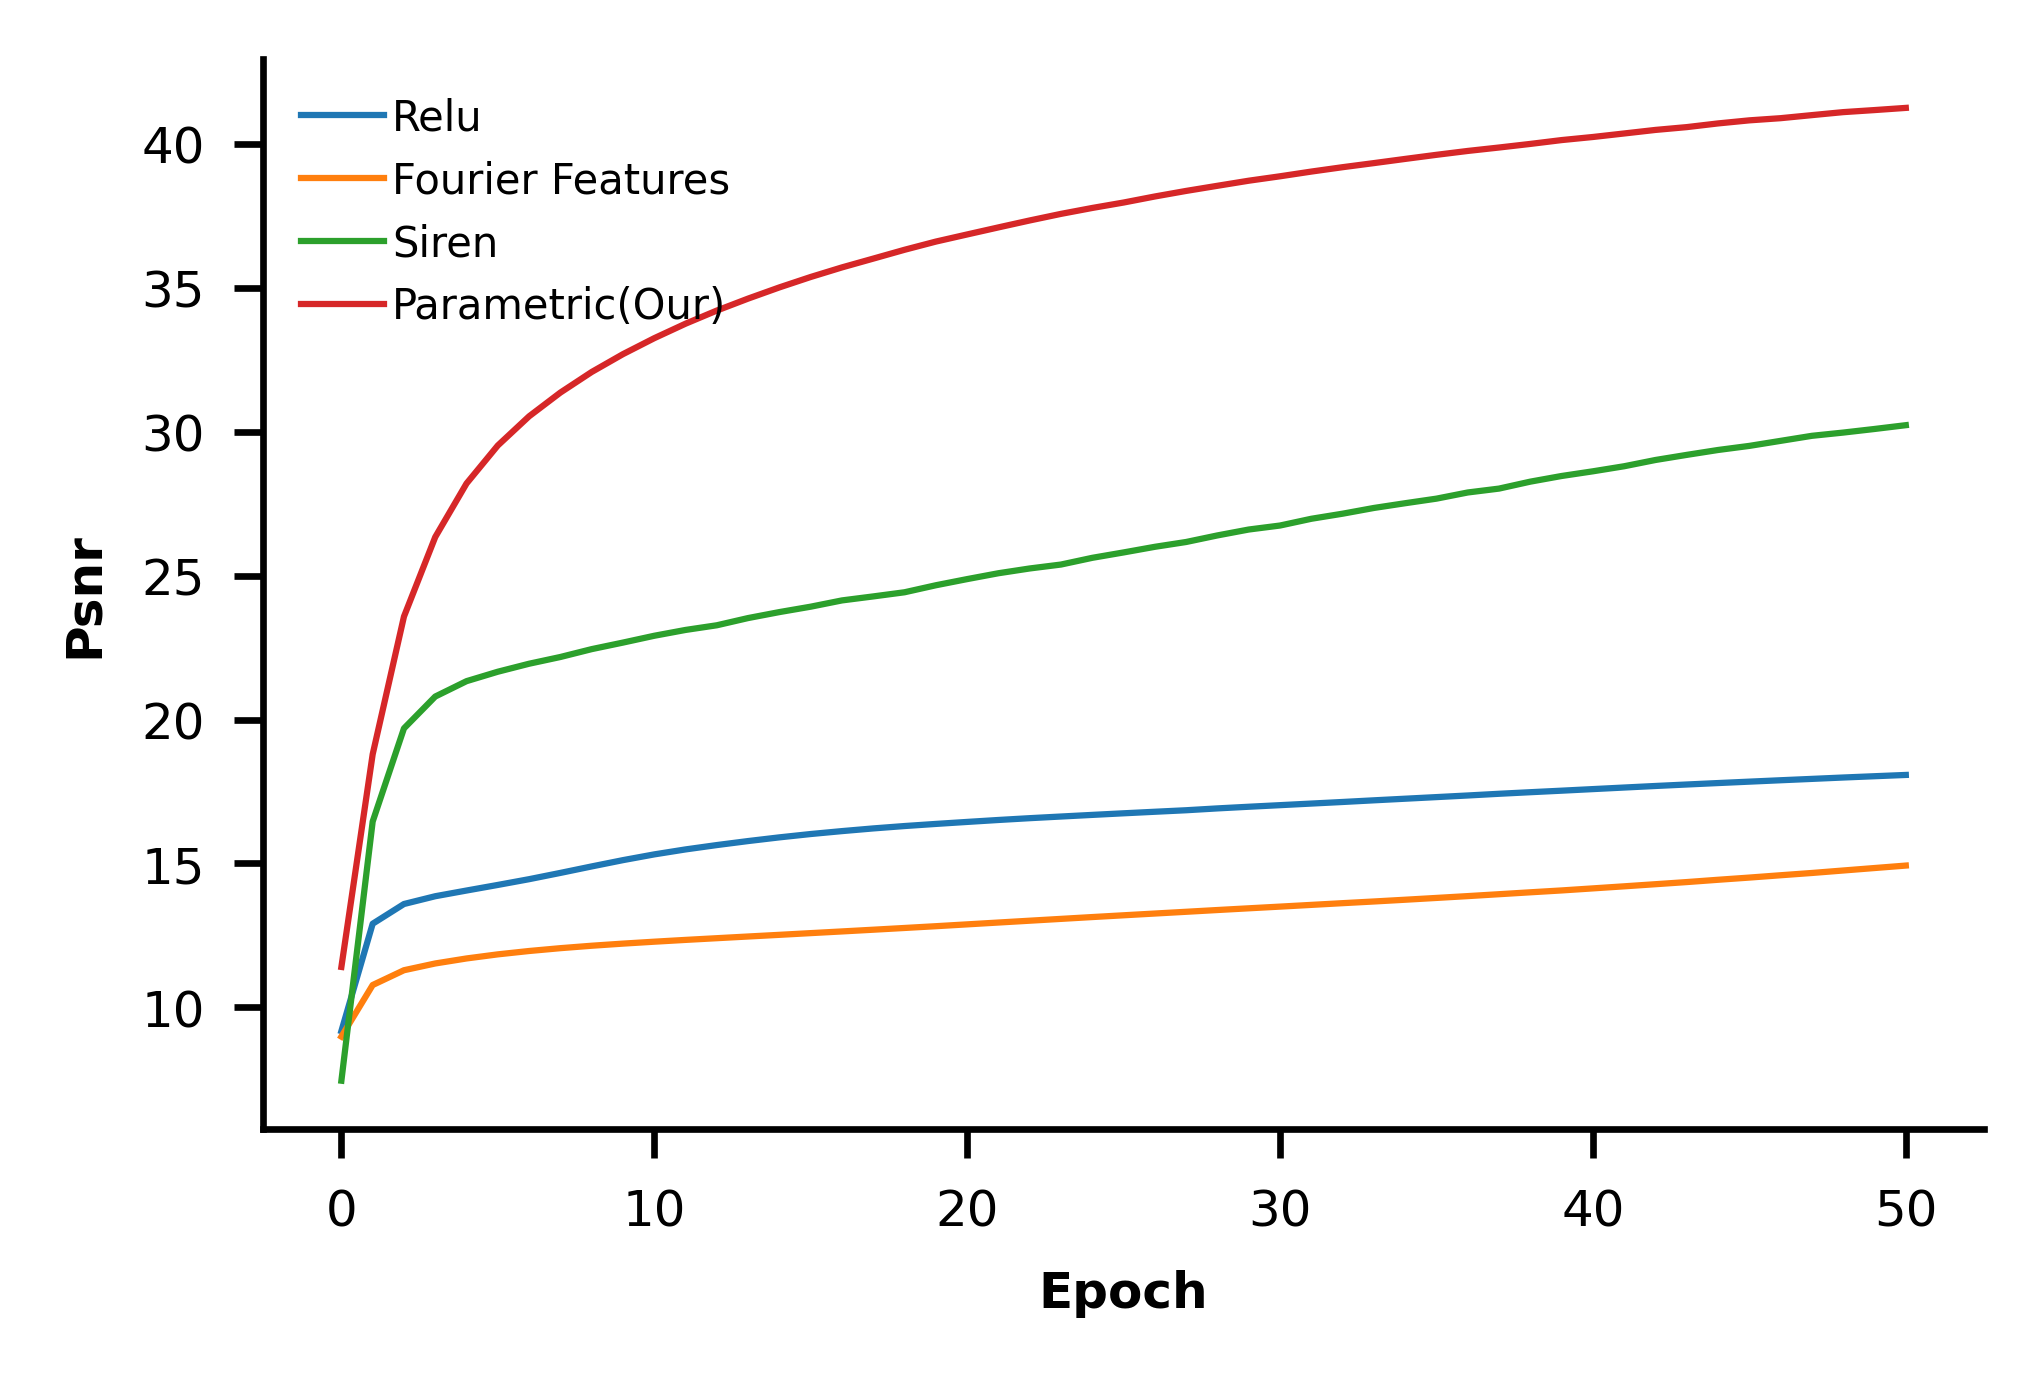

In [163]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
import matplotlib.font_manager as font_manager


def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)



mpl.rcParams['pdf.fonttype'] = 3
mpl.rcParams['ps.fonttype'] = 3
mpl.rcParams['font.family'] = 'Arial'


mpl.rcParams['axes.titlesize'] = 6
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['axes.labelweight'] = "bold"


mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6


mpl.rcParams['legend.fontsize'] = 5



fig = plt.figure(figsize=cm2inch(9.4,6), dpi=600)
ax=plt.axes()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


legend_font = font_manager.FontProperties(family='Arial')


plt.plot(model_psnr.T, linewidth=0.75)



#plt.ylim([0, 50])

#ax.xaxis.set_minor_locator(MultipleLocator(1))
#ax.xaxis.set_major_locator(MultipleLocator(5))
#ax.yaxis.set_major_locator(MultipleLocator(10))
#ax.yaxis.set_minor_locator(MultipleLocator(2))

plt.xlabel('Epoch')
plt.ylabel('Psnr')
ax.legend(['Relu', 'Fourier Features', 'Siren', 'Parametric(Our)'],
          loc='upper left',
          bbox_to_anchor=(0,1),
          handletextpad=0.2,
          frameon=False)


plt.savefig('PSNR_Compresion.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0)

### Buffer Not Matter

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Coordinates, RGB_values))
dataset = dataset.shuffle(len(Coordinates)).batch(batch_size)

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
parametric_model.compile(optimizer=optimizer, loss=loss)

In [ ]:
#history = siren_model.fit(dataset, epochs=50, callbacks=[callback, save_result_siren])
history = parametric_model.fit(dataset, epochs=50, callbacks=[callback, save_result_param])
#history = model.fit(dataset, epochs=150, callbacks=[callback])

Epoch 1/50
16/16 [==============================] - 17s 853ms/step - loss: 0.1038
Epoch 2/50
16/16 [==============================] - 14s 856ms/step - loss: 0.0669
Epoch 3/50
16/16 [==============================] - 14s 853ms/step - loss: 0.0568
Epoch 4/50
16/16 [==============================] - 14s 838ms/step - loss: 0.0507
Epoch 5/50
16/16 [==============================] - 14s 847ms/step - loss: 0.0452
Epoch 6/50
16/16 [==============================] - 14s 851ms/step - loss: 0.0403
Epoch 7/50
16/16 [==============================] - 14s 845ms/step - loss: 0.0361
Epoch 8/50
16/16 [==============================] - 14s 845ms/step - loss: 0.0322
Epoch 9/50
16/16 [==============================] - 14s 847ms/step - loss: 0.0285
Epoch 10/50
16/16 [==============================] - 14s 849ms/step - loss: 0.0250
Epoch 11/50
16/16 [==============================] - 14s 849ms/step - loss: 0.0218
Epoch 12/50
16/16 [==============================] - 14s 856ms/step - loss: 0.0192
Epoch 13/50
1

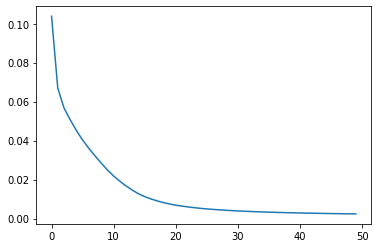

In [ ]:
plt.plot(history.history["loss"])

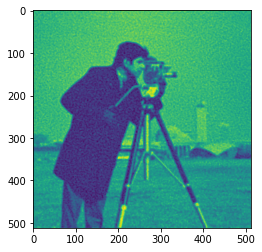

In [ ]:
plt.imshow(save_result_param.images[-1])

In [ ]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [ ]:
predicted = parametric_model.predict(tf.data.Dataset.from_tensor_slices(Coordinates).batch(2048))

PSNR : 40.597125145073264


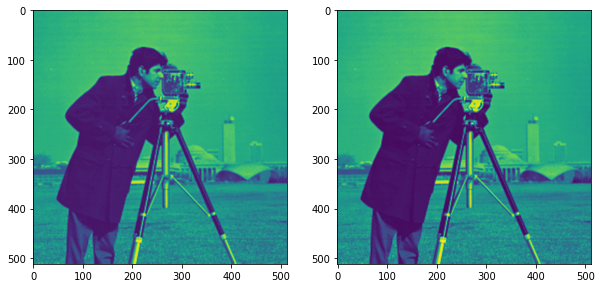

In [ ]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
predicted = predicted.reshape(Image.shape)
plt.imshow(predicted)

plt.subplot(1, 2, 2)
Original = RGB_values.reshape(Image.shape)
plt.imshow(Original)

print(f"PSNR : {PSNR(Original, predicted)}")

In [ ]:
error_plot_image = []



#flag = 0
for image in save_result_param.images:
    buff = image - Image
    #if flag == 0:
    #   MAX = buff.max()
    #   MIN = buff.min()
    #buff = (buff - MIN) / (MAX - MIN)
    buff = (buff - buff.min()) / (buff.max() - buff.min())
    error_plot_image.append(buff)
    #flag += 1

error_plot_image = np.stack(error_plot_image)
reconstructed_image = np.stack(save_result_param.images)
error_plot_image = np.concatenate([reconstructed_image, error_plot_image], axis=-1)



error_plot_image = (255*np.clip(error_plot_image,0,1)).astype(np.uint8)
f = os.path.join('error_plot_image.mp4')
imageio.mimwrite(f, error_plot_image, fps=3)

In [ ]:
images_siren = np.stack(save_result_siren.images, axis=0)
images_param = np.stack(save_result_param.images, axis=0)
images_param_init = np.stack(save_result_param_init.images, axis=0)
images_gt = np.tile(np.expand_dims(Image, axis=0), (50, 1, 1, 1))
images = np.concatenate([images_gt, images_siren, images_param, images_param_init], axis=-2)   
images = (255*np.clip(images,0,1)).astype(np.uint8)
f = os.path.join('training_convergence.mp4')
imageio.mimwrite(f, images, fps=5)

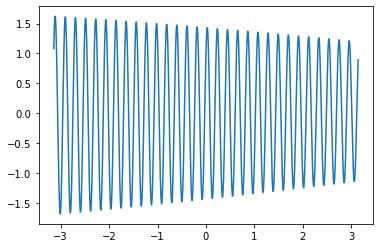

In [ ]:
paraIdx = 27
n_param = 7

weight = model.get_weights()
parameters = weight[paraIdx : paraIdx + n_param]

n = np.linspace(-1*math.pi, 1*math.pi, 10000)
active_plot = parameters[0] * n + \
              parameters[1] * np.sin(parameters[2] * 30 * n + parameters[3]) + \
              parameters[4] * np.cos(parameters[5] * 30 * n + parameters[6])
plt.plot( n, active_plot )

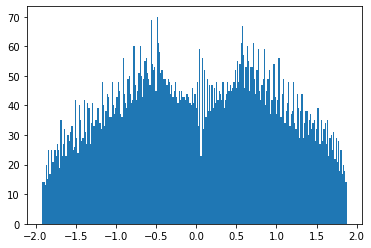

In [ ]:
_ = plt.hist(active_plot, 250)

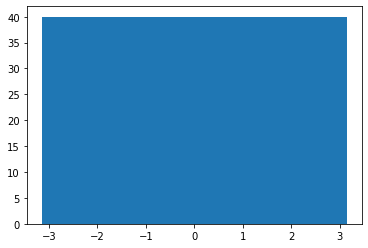

In [ ]:
_ = plt.hist(n, 250)

In [ ]:
X = model.layers[0].input
Y = model.layers[7].output

FirstVisLayer = tf.keras.models.Model(X, Y)

In [ ]:
layer1_predicted = FirstVisLayer.predict(tf.data.Dataset.from_tensor_slices(Coordinates).batch(2048))
layer1_predicted = layer1_predicted.transpose().reshape((Image.shape[0], Image.shape[0], hidden_units))

In [ ]:
for counter in range(256):
    buff = (layer1_predicted[..., counter] - layer1_predicted[..., counter].min()) / (layer1_predicted[..., counter].max() - layer1_predicted[..., counter].min())
    plt.imshow(buff)
    plt.show()

In [ ]:
n = 10
weight_layer2 = model.layers[2].weights[7].numpy()
neuron = weight_layer2[:,n]
neuron = (neuron - neuron.min()) / (neuron.max() - neuron.min())
plt.imshow(neuron.reshape((16, 16)))

# For Audio

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import math
import time
import os
from math import log10, sqrt 

import scipy.io.wavfile as wavfile
import io
from IPython.display import Audio

print("numpy version : {}".format(np.__version__))
print("tensorflow version : {}".format(tf.__version__))

numpy version : 1.19.5
tensorflow version : 2.5.0


In [ ]:
if not os.path.exists('gt_bach.wav'):
    !wget https://vsitzmann.github.io/siren/img/audio/gt_bach.wav

In [ ]:
rate, data = wavfile.read('gt_bach.wav')

#model_input, ground_truth = next(iter(dataloader))
Audio(data.squeeze(),rate=rate)

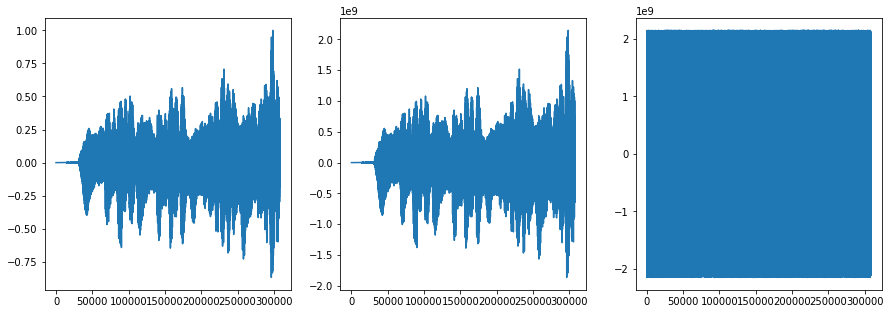

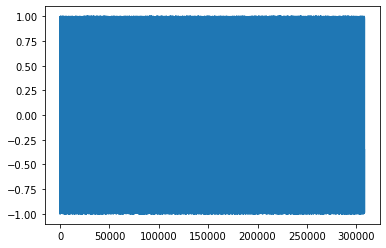

In [ ]:
buff = data * 2 ** 31
random_xor = np.random.randint(-2**31, 2**31 - 1, len(buff))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(data)

plt.subplot(1, 3, 2)
plt.plot(buff)

plt.subplot(1, 3, 3)
plt.plot(buff.astype('int32') ^ random_xor)

plt.figure()
after_xor = buff.astype('int32') ^ random_xor
after_xor = after_xor.astype('int32') / 2 ** 31
plt.plot(after_xor)

In [ ]:
filename = "gt_bach.wav"

rate, data = wavfile.read(filename)
data = data.astype(np.float32)
scale = np.max(np.abs(data))
data = (data / scale)

timepoints = np.linspace(-1, +1, len(data))

In [ ]:
Audio(data.squeeze(),rate=rate)

In [ ]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr

In [ ]:
tf.keras.backend.clear_session()





batch_size = 16 * 1024


n_fourier_features = 10
scale = 10

B = np.random.randn(1, n_fourier_features)
B = scale * B



class CustomSaver(tf.keras.callbacks.Callback):
    def __init__(self, voice_len, is_fourier=False):
        super(CustomSaver, self).__init__()
        self.voice_len = voice_len

        self.data = np.expand_dims(np.linspace(-1, +1, self.voice_len), axis=-1)
        if is_fourier:
          self.data = self.data @ B
          self.data = np.concatenate([np.sin(2 * math.pi * self.data), np.cos(2 * math.pi * self.data)], axis=-1)
          self.data = tf.data.Dataset.from_tensor_slices(self.data).batch(batch_size)
        else:
          self.data = tf.data.Dataset.from_tensor_slices(self.data).batch(batch_size)
        self.voices = []
    def on_epoch_end(self, epoch, logs={}):
        self.voices.append(self.model.predict(self.data))

save_result_siren = CustomSaver(len(data))
save_result_param = CustomSaver(len(data))
save_result_relu = CustomSaver(len(data))
save_result_fourier = CustomSaver((len(data)), is_fourier=True)

In [ ]:
omega_0 = 30
hidden_units = 256

hidden_initializers = tf.keras.initializers.RandomUniform(minval=-np.sqrt(6/hidden_units)/omega_0, maxval=np.sqrt(6/hidden_units)/omega_0)

In [ ]:
## SIREN Model
X = tf.keras.layers.Input(shape=(1,))
x1 = SineLayer(2, hidden_units, is_first=True, omega_0=1500)(X)
x2 = SineLayer(hidden_units, hidden_units, is_first=False)(x1)
x3 = SineLayer(hidden_units, hidden_units, is_first=False)(x2)
x4 = SineLayer(hidden_units, hidden_units, is_first=False)(x3)

x = tf.keras.layers.Add()([x1, x2, x3, x4])

Y = tf.keras.layers.Dense(1, kernel_initializer=hidden_initializers)(x)

siren_model = tf.keras.models.Model(X, Y)

In [ ]:
## Parametric Model
X = tf.keras.layers.Input(shape=(1,))
x1 = ParaSineLayer(2, hidden_units, is_first=True, omega_0=500)(X)
x2 = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x1)
x3 = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x2)
x4 = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x3)

x = tf.keras.layers.Add()([x1, x2, x3, x4])

Y = tf.keras.layers.Dense(1, kernel_initializer=hidden_initializers)(x)

parametric_model = tf.keras.models.Model(X, Y)

In [ ]:
## Fourier Model
X = tf.keras.layers.Input(shape=(2 * n_fourier_features,))
x1 = tf.keras.layers.Dense(hidden_units, activation='relu')(X)
x2 = tf.keras.layers.Dense(hidden_units, activation='relu')(x1)
x3 = tf.keras.layers.Dense(hidden_units, activation='relu')(x2)
x4 = tf.keras.layers.Dense(hidden_units, activation='relu')(x3)

x = tf.keras.layers.Add()([x1, x2, x3, x4])

Y = tf.keras.layers.Dense(1)(x)

fourier_model = tf.keras.models.Model(X, Y)

In [ ]:
## Relu Model
X = tf.keras.layers.Input(shape=(1,))
x1 = tf.keras.layers.Dense(hidden_units, activation='relu')(X)
x2 = tf.keras.layers.Dense(hidden_units, activation='relu')(x1)
x3 = tf.keras.layers.Dense(hidden_units, activation='relu')(x2)
x4 = tf.keras.layers.Dense(hidden_units, activation='relu')(x3)

x = tf.keras.layers.Add()([x1, x2, x3, x4])

Y = tf.keras.layers.Dense(1)(x)

relu_model = tf.keras.models.Model(X, Y)

In [ ]:
fourier_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 20)]         0                                            
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 256)          5376        input_3[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 256)          65792       dense_10[0][0]                   
__________________________________________________________________________________________________
dense_12 (Dense)                (None, 256)          65792       dense_11[0][0]                   
____________________________________________________________________________________________

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    if epoch % 5 == 0:
        lr = lr * tf.math.exp(-0.15)
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
models = [relu_model,
          fourier_model,
          siren_model,
          parametric_model]

callbacks = [save_result_relu,
             save_result_fourier,
             save_result_siren,
             save_result_param]

with_fourier = [False,
                True,
                False,
                False]


History = []

epochs = 50
for counter in range(len(models)):

    timepoints = np.linspace(-1, +1, len(data))
    if with_fourier[counter]:
       timepoints = np.expand_dims(timepoints, axis=-1)
       timepoints = timepoints @ B
       timepoints = np.concatenate([np.sin(2 * math.pi * timepoints), np.cos(2 * math.pi * timepoints)], axis=-1)
    
    dataset = tf.data.Dataset.from_tensor_slices((timepoints, data))
    dataset = dataset.shuffle(len(data)).batch(batch_size)

    optimizer = tf.keras.optimizers.Adam(1e-4)
    loss = tf.keras.losses.MeanSquaredError() 

    models[counter].compile(optimizer=optimizer, loss=loss)

    print(20*"*", counter, 20*"*")
    history = models[counter].fit(dataset, epochs=epochs, callbacks=[callback, callbacks[counter]])
    History.append(history.history['loss'])

******************** 0 ********************
Epoch 1/50
19/19 [==============================] - 4s 32ms/step - loss: 0.0242
Epoch 2/50
19/19 [==============================] - 1s 35ms/step - loss: 0.0242
Epoch 3/50
19/19 [==============================] - 1s 35ms/step - loss: 0.0242
Epoch 4/50
19/19 [==============================] - 1s 35ms/step - loss: 0.0242
Epoch 5/50
19/19 [==============================] - 1s 35ms/step - loss: 0.0242
Epoch 6/50
19/19 [==============================] - 1s 34ms/step - loss: 0.0242
Epoch 7/50
19/19 [==============================] - 1s 35ms/step - loss: 0.0242
Epoch 8/50
19/19 [==============================] - 1s 34ms/step - loss: 0.0242
Epoch 9/50
19/19 [==============================] - 1s 35ms/step - loss: 0.0242
Epoch 10/50
19/19 [==============================] - 1s 36ms/step - loss: 0.0242
Epoch 11/50
19/19 [==============================] - 1s 35ms/step - loss: 0.0242
Epoch 12/50
19/19 [==============================] - 1s 35ms/step - loss: 

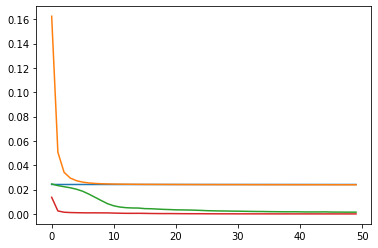

In [ ]:
plt.plot(np.stack(History).T)

In [ ]:
psnr_buff = []
for voice in callbacks[0].voices:
    voice = np.squeeze(voice)
    psnr_buff.append(PSNR(data, voice))

In [ ]:
Voice = []
model_psnr = []
for save_result in callbacks:
  psnr_buff = []
  Voice.append(np.stack(save_result.voices))
  for voice in save_result.voices:
      voice = np.squeeze(voice)
      psnr_buff.append(PSNR(data, voice))
  model_psnr.append(psnr_buff)

model_psnr = np.stack(model_psnr)
Voice = np.squeeze(np.stack(Voice))

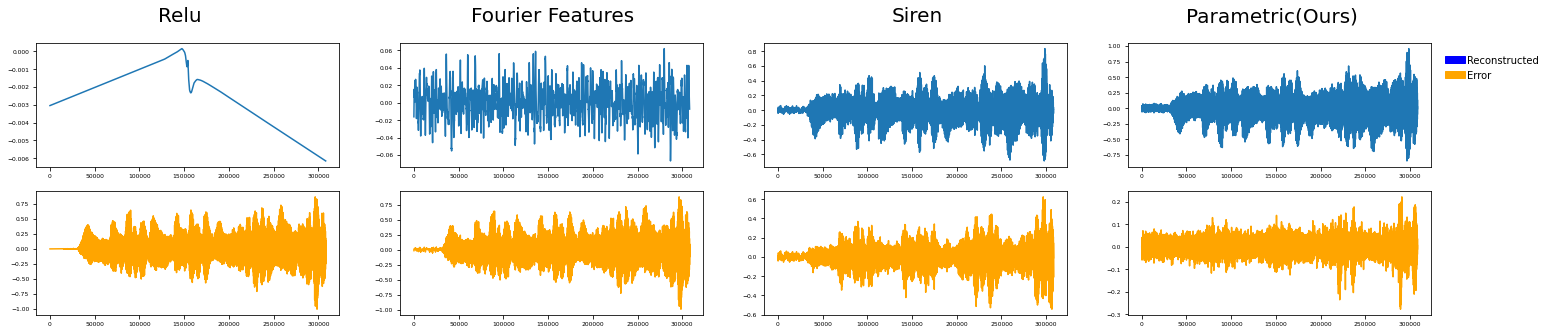

In [ ]:
text_font = {'fontname':'Arial', 'size':'20'}
mpl.rcParams['legend.fontsize'] = 50

Iter = 10
plt.figure(figsize=(25, 5))

label = ['Relu', 'Fourier Features', 'Siren', 'Parametric(Ours)']

for counter in range(len(Voice)):
    plt.subplot(2, len(Voice), counter + 1)
    plt.plot(Voice[counter, Iter, :])

    

    plt.subplot(2, len(Voice), len(Voice) + counter + 1)
    plt.plot(Voice[counter, Iter, :] - data, 'orange')

plt.text(-1100000, 1, label[0], **text_font)  
plt.text(-750000, 1, label[1], **text_font)  
plt.text(-280000, 1, label[2], **text_font)    
plt.text(50000, 1, label[3], **text_font)


colors = {'Reconstructed':'b', 'Error':'orange'}         
labels = list(colors.keys())
handles = [plt.Rectangle((0,0),1,1, color=colors[label]) for label in labels]

plt.legend(handles,
           labels,
           bbox_to_anchor=(1.2,2),
           loc='center',
           ncol=1,
           prop=legend_font,
           handletextpad=0.2,
           frameon=False)

plt.savefig('Compresion_on_Epoch20_Voice.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0)

In [ ]:
plt.xticks([])
plt.yticks([])
plt.text(1 * 256 - 100, -20, 'Original', **text_font)
plt.text(3 * 256 - 50 , -20, 'Relu', **text_font)
plt.text(5 * 256 - 120, -20, 'Fourier Features', **text_font)
plt.text(7 * 256 - 50 , -20, 'Siren', **text_font)
plt.text(9 * 256 - 140, -20, 'Parametric(Ours)', **text_font)

#plt.savefig('Compresion_on_Epoch20.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0)

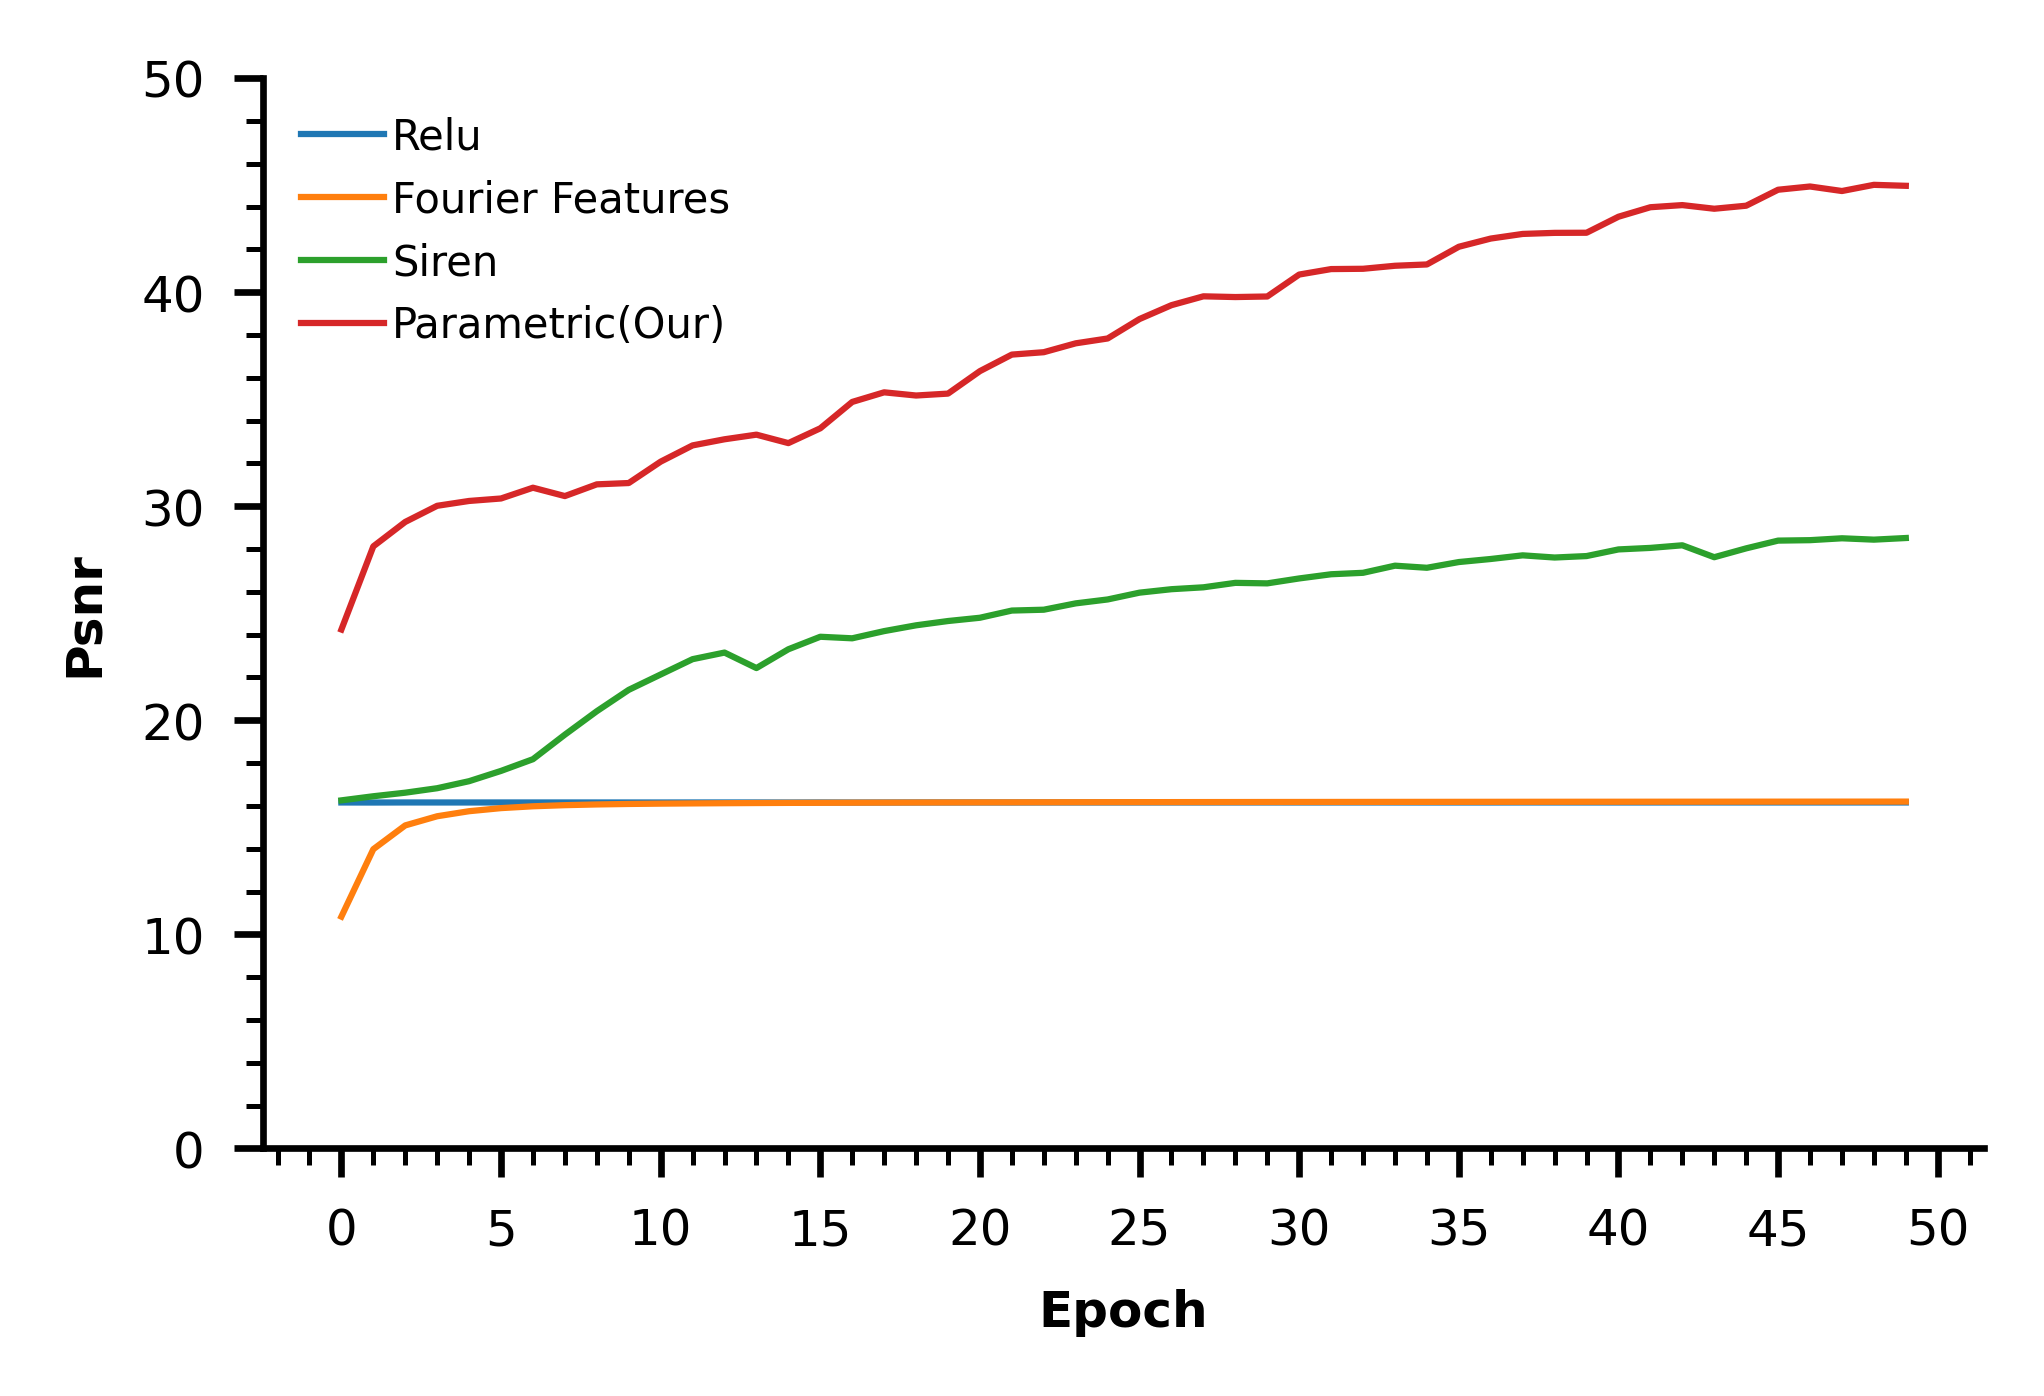

In [ ]:
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator
import matplotlib.font_manager as font_manager


def cm2inch(*tupl):
    inch = 2.54
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)



mpl.rcParams['pdf.fonttype'] = 3
mpl.rcParams['ps.fonttype'] = 3
mpl.rcParams['font.family'] = 'Arial'


mpl.rcParams['axes.titlesize'] = 6
mpl.rcParams['axes.labelsize'] = 6
mpl.rcParams['axes.labelweight'] = "bold"


mpl.rcParams['xtick.labelsize'] = 6
mpl.rcParams['ytick.labelsize'] = 6


mpl.rcParams['legend.fontsize'] = 5



fig = plt.figure(figsize=cm2inch(9.4,6), dpi=600)
ax=plt.axes()


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)


legend_font = font_manager.FontProperties(family='Arial')


plt.plot(model_psnr.T, linewidth=0.75)



plt.ylim([0, 50])

ax.xaxis.set_minor_locator(MultipleLocator(1))
ax.xaxis.set_major_locator(MultipleLocator(5))
ax.yaxis.set_major_locator(MultipleLocator(10))
ax.yaxis.set_minor_locator(MultipleLocator(2))

plt.xlabel('Epoch')
plt.ylabel('Psnr')
ax.legend(['Relu', 'Fourier Features', 'Siren', 'Parametric(Our)'],
          loc='upper left',
          bbox_to_anchor=(0,1),
          handletextpad=0.2,
          frameon=False)


plt.savefig('PSNR_Compresion.pdf', format='pdf', dpi=600, bbox_inches='tight', pad_inches=0)

In [ ]:
ls

1.jpg                            CT.jpg
Compresion_on_Epoch10.pdf        gt_bach.wav
Compresion_on_Epoch20.pdf        PSNR_Compresion.pdf
Compresion_on_Epoch20_Voice.pdf  sample_data/
Compresion_on_Epoch5.pdf         training_convergence.mp4


In [ ]:
  from google.colab import files
  files.download('Compresion_on_Epoch20_Voice.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((timepoints, data))
dataset = dataset.shuffle(len(data)).batch(1024 * 16)

#dataset = tf.data.Dataset.from_tensor_slices((timepoints, after_xor))
#dataset = dataset.shuffle(len(after_xor)).batch(1024 * 16)

In [ ]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)

    
    def init_weights(self):

        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
        #if self.is_first:
        #    return tf.keras.initializers.RandomUniform(minval=-1 / self.in_features,
        #                                               maxval= 1 / self.in_features)
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w0 = self.add_weight(
            name='w0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift0 = self.add_weight(
            name='shift0',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift1 = self.add_weight(
            name='shift1',
            shape=(1,),
            initializer='zeros',
            trainable=True)


        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * self.omega_0 * befor_activation + \
                           self.a0 * tf.sin(self.w0 * self.omega_0 * befor_activation + self.shift0) + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation + self.shift1)
        return after_activation

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [ ]:
class ParaSineLayer(tf.keras.layers.Layer):
    def __init__(self, in_features, units, bias=True, is_first=False, omega_0=30.):
        super(ParaSineLayer, self).__init__()
        self.in_features = in_features
        self.units = units
        self.is_first = is_first
        self.omega_0 = omega_0

        self.dense = tf.keras.layers.Dense(self.units,
                                           use_bias=bias,
                                           kernel_initializer=self.init_weights(),
                                           input_shape=(self.in_features,))
        
    

    def cal_limit(self):
        X = 2 * np.random.rand(1000, self.in_features) - 1
        W = 2 * np.random.rand(self.in_features, self.units) - 1
        A = np.matmul(X, W)
        return np.std(A)

    def init_weights(self):
        if self.is_first:
            return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit()),
                                                       maxval= 1 / (self.cal_limit()))
            
        else:
            return tf.keras.initializers.RandomUniform(minval=-np.sqrt(6. / self.in_features) / self.omega_0,
                                                       maxval= np.sqrt(6. / self.in_features) / self.omega_0)
        
        #else:
        #    return tf.keras.initializers.RandomUniform(minval=-1 / (self.cal_limit() * self.omega_0),
        #                                               maxval= 1 / (self.cal_limit() * self.omega_0))
    

    def build(self, input_shape):

        self.a_1 = self.add_weight(
            name='a_1',
            shape=(1,),
            initializer='zeros',
            trainable=True)


        self.a0 = self.add_weight(
            name='a0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w0 = self.add_weight(
            name='w0',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift0 = self.add_weight(
            name='shift0',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a1 = self.add_weight(
            name='a1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.w1 = self.add_weight(
            name='w1',
            shape=(1,),
            initializer='ones',
            trainable=True)
        self.shift1 = self.add_weight(
            name='shift1',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        


        self.a2 = self.add_weight(
            name='a2',
            shape=(1,),
            initializer=tf.keras.initializers.constant(1/2.),
            trainable=True)
        self.w2 = self.add_weight(
            name='w2',
            shape=(1,),
            initializer=tf.keras.initializers.constant(2.),
            trainable=True)
        self.shift2 = self.add_weight(
            name='shift2',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a3 = self.add_weight(
            name='a3',
            shape=(1,),
            initializer=tf.keras.initializers.constant(1/2.),
            trainable=True)
        self.w3 = self.add_weight(
            name='w3',
            shape=(1,),
            initializer=tf.keras.initializers.constant(2.),
            trainable=True)
        self.shift3 = self.add_weight(
            name='shift3',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        


        self.a4 = self.add_weight(
            name='a4',
            shape=(1,),
            initializer=tf.keras.initializers.constant(1/3.),
            trainable=True)
        self.w4 = self.add_weight(
            name='w4',
            shape=(1,),
            initializer=tf.keras.initializers.constant(3.),
            trainable=True)
        self.shift4 = self.add_weight(
            name='shift4',
            shape=(1,),
            initializer='zeros',
            trainable=True)

        self.a5 = self.add_weight(
            name='a5',
            shape=(1,),
            initializer=tf.keras.initializers.constant(1/3.),
            trainable=True)
        self.w5 = self.add_weight(
            name='w5',
            shape=(1,),
            initializer=tf.keras.initializers.constant(3.),
            trainable=True)
        self.shift5 = self.add_weight(
            name='shift5',
            shape=(1,),
            initializer='zeros',
            trainable=True)
        

        super(ParaSineLayer, self).build(input_shape)


    def call(self, input_tensor):
        befor_activation = self.dense(input_tensor)
        after_activation = self.a_1 * self.omega_0 * befor_activation + \
                           self.a0 * tf.sin(self.w0 * self.omega_0 * befor_activation + self.shift0) + \
                           self.a1 * tf.cos(self.w1 * self.omega_0 * befor_activation + self.shift1) + \
                           self.a2 * tf.sin(self.w2 * self.omega_0 * befor_activation + self.shift2) + \
                           self.a3 * tf.cos(self.w3 * self.omega_0 * befor_activation + self.shift3) + \
                           self.a4 * tf.sin(self.w4 * self.omega_0 * befor_activation + self.shift4) + \
                           self.a5 * tf.cos(self.w5 * self.omega_0 * befor_activation + self.shift5)
        return after_activation

    def compute_output_shape(self, input_shape):
        return (input_shape[0], self.units)

In [ ]:
tf.keras.backend.clear_session()

hidden_units = 256
hidden_initializers = tf.keras.initializers.RandomUniform(minval=-np.sqrt(6/hidden_units)/30, maxval=np.sqrt(6/hidden_units)/30)

In [ ]:
## Parametric Model
X = tf.keras.layers.Input(shape=(1,))
x = ParaSineLayer(1, hidden_units, is_first=True, omega_0=500.)(X)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)
x = ParaSineLayer(hidden_units, hidden_units, is_first=False)(x)

Y = tf.keras.layers.Dense(1, kernel_initializer=hidden_initializers)(x)

model = tf.keras.models.Model(X, Y)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1)]               0         
_________________________________________________________________
para_sine_layer (ParaSineLay (None, 256)               531       
_________________________________________________________________
para_sine_layer_1 (ParaSineL (None, 256)               65811     
_________________________________________________________________
para_sine_layer_2 (ParaSineL (None, 256)               65811     
_________________________________________________________________
para_sine_layer_3 (ParaSineL (None, 256)               65811     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 257       
Total params: 198,221
Trainable params: 198,221
Non-trainable params: 0
_______________________________________________________

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    if epoch % 5 == 0:
        lr = lr * tf.math.exp(-0.15)
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-4)
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
model.compile(optimizer=optimizer, loss=loss)

In [ ]:
history = model.fit(dataset, epochs=30, callbacks=[callback])
#history = model.fit(dataset, epochs=30)

Epoch 1/30
19/19 [==============================] - 4s 87ms/step - loss: 0.0194
Epoch 2/30
19/19 [==============================] - 2s 87ms/step - loss: 0.0036
Epoch 3/30
19/19 [==============================] - 2s 86ms/step - loss: 0.0023
Epoch 4/30
19/19 [==============================] - 2s 87ms/step - loss: 0.0019
Epoch 5/30
19/19 [==============================] - 2s 86ms/step - loss: 0.0015
Epoch 6/30
19/19 [==============================] - 2s 87ms/step - loss: 0.0012
Epoch 7/30
19/19 [==============================] - 2s 87ms/step - loss: 9.4590e-04
Epoch 8/30
19/19 [==============================] - 2s 87ms/step - loss: 7.5742e-04
Epoch 9/30
19/19 [==============================] - 2s 86ms/step - loss: 6.0903e-04
Epoch 10/30
19/19 [==============================] - 2s 87ms/step - loss: 5.0517e-04
Epoch 11/30
19/19 [==============================] - 2s 88ms/step - loss: 3.9856e-04
Epoch 12/30
19/19 [==============================] - 2s 86ms/step - loss: 3.0380e-04
Epoch 13/30
1

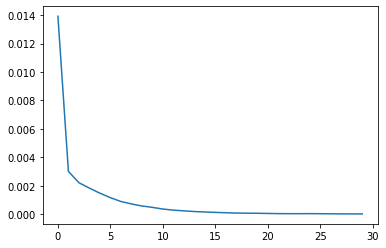

In [ ]:
plt.plot(history.history["loss"])

In [ ]:
predicted = model.predict(tf.data.Dataset.from_tensor_slices(timepoints).batch(1024 * 16))

In [ ]:
Audio(predicted.squeeze(), rate=rate)

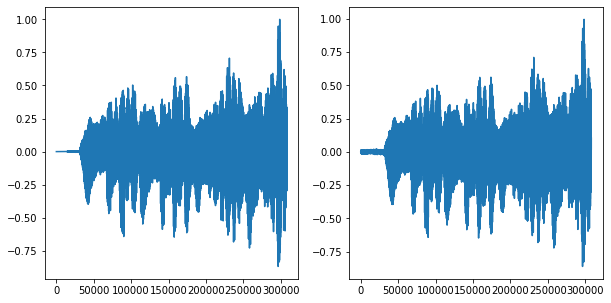

In [ ]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
Original = data
plt.plot(Original)

plt.subplot(1, 2, 2)
predicted = predicted.squeeze()
plt.plot(predicted)

In [ ]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [ ]:
# param psnr
print(f"Param PSNR : {PSNR(Original, predicted)}")

Param PSNR : 45.04295903829835


# Spectral Normalization

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import skimage
import math
import time
from math import log10, sqrt 

print("numpy version : {}".format(np.__version__))
print("tensorflow version : {}".format(tf.__version__))

numpy version : 1.19.5
tensorflow version : 2.5.0


(300, 300) 1.0


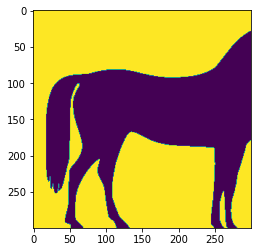

In [ ]:
Image = skimage.data.horse()
Image = Image.astype(np.float32)
Image = Image[:300, :300]
print(Image.shape, Image.max())
plt.imshow(Image)

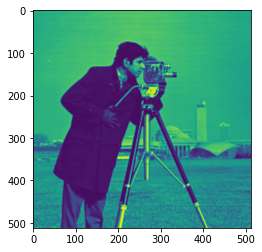

In [ ]:
Image = skimage.data.camera()
plt.imshow(Image)

In [ ]:
Image = Image.astype(np.float32)
Image = Image / 255

In [ ]:
def make_coordiante(shape):
    x_coordinates = np.linspace(-1, +1, shape[0])
    y_coordinates = np.linspace(-1, +1, shape[1])
    x_coordinates, y_coordinates = np.meshgrid(x_coordinates, y_coordinates)
    x_coordinates = x_coordinates.flatten()
    y_coordinates = y_coordinates.flatten()
    Coordinates = np.stack([x_coordinates, y_coordinates]).T
    return Coordinates

In [ ]:
Coordinates = make_coordiante(Image.shape)

In [ ]:
RGB_values = Image.flatten()

In [ ]:
class SpectralNormalization(tf.keras.layers.Wrapper):
  """Implements spectral normalization for Dense layer."""

  def __init__(self,
               layer,
               iteration=1,
               norm_multiplier=0.95,
               training=True,
               aggregation=tf.VariableAggregation.MEAN,
               inhere_layer_name=False,
               **kwargs):
    """Initializer.
    Args:
      layer: (tf.keras.layers.Layer) A TF Keras layer to apply normalization to.
      iteration: (int) The number of power iteration to perform to estimate
        weight matrix's singular value.
      norm_multiplier: (float) Multiplicative constant to threshold the
        normalization. Usually under normalization, the singular value will
        converge to this value.
      training: (bool) Whether to perform power iteration to update the singular
        value estimate.
      aggregation: (tf.VariableAggregation) Indicates how a distributed variable
        will be aggregated. Accepted values are constants defined in the class
        tf.VariableAggregation.
      inhere_layer_name: (bool) Whether to inhere the name of the input layer.
      **kwargs: (dict) Other keyword arguments for the layers.Wrapper class.
    """
    self.iteration = iteration
    self.do_power_iteration = training
    self.aggregation = aggregation
    self.norm_multiplier = norm_multiplier

    # Set layer name.
    wrapper_name = kwargs.pop('name', None)
    if inhere_layer_name:
      wrapper_name = layer.name

    if not isinstance(layer, tf.keras.layers.Layer):
      raise ValueError('`layer` must be a `tf.keras.layer.Layer`. '
                       'Observed `{}`'.format(layer))
    super(SpectralNormalization, self).__init__(
        layer, name=wrapper_name, **kwargs)

  def build(self, input_shape):
    super(SpectralNormalization, self).build(input_shape)
    self.layer.kernel._aggregation = self.aggregation  # pylint: disable=protected-access
    self._dtype = self.layer.kernel.dtype

    self.w = self.layer.kernel
    self.w_shape = self.w.shape.as_list()
    self.uv_initializer = tf.initializers.random_normal()

    self.v = self.add_weight(
        shape=(1, np.prod(self.w_shape[:-1])),
        initializer=self.uv_initializer,
        trainable=False,
        name='v',
        dtype=self.dtype,
        aggregation=self.aggregation)

    self.u = self.add_weight(
        shape=(1, self.w_shape[-1]),
        initializer=self.uv_initializer,
        trainable=False,
        name='u',
        dtype=self.dtype,
        aggregation=self.aggregation)

    self.update_weights()

  def call(self, inputs, *, training=None):
    training = self.do_power_iteration if training is None else training
    u_update_op, v_update_op, w_update_op = self.update_weights(
        training=training)
    output = self.layer(inputs)
    w_restore_op = self.restore_weights()

    # Register update ops.
    self.add_update(u_update_op)
    self.add_update(v_update_op)
    self.add_update(w_update_op)
    self.add_update(w_restore_op)

    return output

  def update_weights(self, *, training=True):
    w_reshaped = tf.reshape(self.w, [-1, self.w_shape[-1]])

    u_hat = self.u
    v_hat = self.v

    if training:
      for _ in range(self.iteration):
        v_hat = tf.nn.l2_normalize(tf.matmul(u_hat, tf.transpose(w_reshaped)))
        u_hat = tf.nn.l2_normalize(tf.matmul(v_hat, w_reshaped))

    sigma = tf.matmul(tf.matmul(v_hat, w_reshaped), tf.transpose(u_hat))
    # Convert sigma from a 1x1 matrix to a scalar.
    sigma = tf.reshape(sigma, [])
    u_update_op = self.u.assign(u_hat)
    v_update_op = self.v.assign(v_hat)

    # Bound spectral norm to be not larger than self.norm_multiplier.
    w_norm = tf.cond((self.norm_multiplier / sigma) < 1, lambda:  # pylint:disable=g-long-lambda
                     (self.norm_multiplier / sigma) * self.w, lambda: self.w)

    w_update_op = self.layer.kernel.assign(w_norm)
    return u_update_op, v_update_op, w_update_op

  def restore_weights(self):
    """Restores layer weights to maintain gradient update (See Alg 1 of [1])."""
    return self.layer.kernel.assign(self.w)

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
hidden_units = 256

In [ ]:
hidden_initializers = tf.keras.initializers.RandomUniform(minval=-np.sqrt(6/hidden_units)/30, maxval=np.sqrt(6/hidden_units)/30)

In [ ]:
X = tf.keras.layers.Input(shape=(2,))

x = SpectralNormalization(tf.keras.layers.Dense(units=hidden_units), norm_multiplier=0.9)(X)
#x = tf.keras.layers.Dense(units=hidden_units)(X)
x = tf.keras.layers.ReLU()(x)
#x = tf.keras.layers.Lambda(lambda x: tf.sin(30 * x))(x)

x = SpectralNormalization(tf.keras.layers.Dense(units=hidden_units), norm_multiplier=0.9)(x)
#x = tf.keras.layers.Dense(units=hidden_units)(x)
x = tf.keras.layers.ReLU()(x)
#x = tf.keras.layers.Lambda(lambda x: tf.sin(30 * x))(x)

x = SpectralNormalization(tf.keras.layers.Dense(units=hidden_units), norm_multiplier=0.9)(x)
#x = tf.keras.layers.Dense(units=hidden_units)(x)
x = tf.keras.layers.ReLU()(x)
#x = tf.keras.layers.Lambda(lambda x: tf.sin(30 * x))(x)

x = SpectralNormalization(tf.keras.layers.Dense(units=hidden_units), norm_multiplier=0.9)(x)
#x = tf.keras.layers.Dense(units=hidden_units)(x)
x = tf.keras.layers.ReLU()(x)
#x = tf.keras.layers.Lambda(lambda x: tf.sin(30 * x))(x)

Y = tf.keras.layers.Dense(1, kernel_initializer=hidden_initializers)(x)

model = tf.keras.models.Model(X, Y)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
spectral_normalization (Spec (None, 256)               1026      
_________________________________________________________________
re_lu (ReLU)                 (None, 256)               0         
_________________________________________________________________
spectral_normalization_1 (Sp (None, 256)               66304     
_________________________________________________________________
re_lu_1 (ReLU)               (None, 256)               0         
_________________________________________________________________
spectral_normalization_2 (Sp (None, 256)               66304     
_________________________________________________________________
re_lu_2 (ReLU)               (None, 256)               0     

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((Coordinates, RGB_values))
dataset = dataset.shuffle(len(Coordinates)).batch(16 * 1024)

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    if epoch % 10 == 0:
        lr = lr * tf.math.exp(-0.15)
    return lr
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [ ]:
optimizer = tf.keras.optimizers.Adam(1e-3)
loss = tf.keras.losses.MeanSquaredError()

In [ ]:
model.compile(optimizer=optimizer, loss=loss)

In [ ]:
history = model.fit(dataset, epochs=30, callbacks=[callback])

Epoch 1/30
6/6 [==============================] - 1s 31ms/step - loss: 0.5830
Epoch 2/30
6/6 [==============================] - 0s 33ms/step - loss: 0.5268
Epoch 3/30
6/6 [==============================] - 0s 32ms/step - loss: 0.4589
Epoch 4/30
6/6 [==============================] - 0s 31ms/step - loss: 0.3584
Epoch 5/30
6/6 [==============================] - 0s 32ms/step - loss: 0.2711
Epoch 6/30
6/6 [==============================] - 0s 33ms/step - loss: 0.2332
Epoch 7/30
6/6 [==============================] - 0s 31ms/step - loss: 0.2378
Epoch 8/30
6/6 [==============================] - 0s 31ms/step - loss: 0.2297
Epoch 9/30
6/6 [==============================] - 0s 33ms/step - loss: 0.2272
Epoch 10/30
6/6 [==============================] - 0s 31ms/step - loss: 0.2242
Epoch 11/30
6/6 [==============================] - 0s 32ms/step - loss: 0.2217
Epoch 12/30
6/6 [==============================] - 0s 33ms/step - loss: 0.2204
Epoch 13/30
6/6 [==============================] - 0s 32ms/st

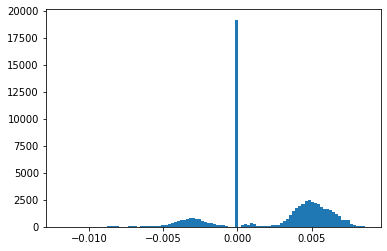

In [ ]:
buff = model.layers[3]
_ = plt.hist(buff.weights[0].numpy().flatten(), 100)

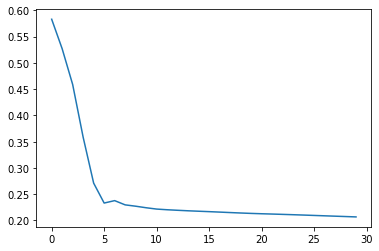

In [ ]:
plt.plot(history.history["loss"])

In [ ]:
def PSNR(original, compressed): 
    mse = np.mean((original - compressed) ** 2) 
    if(mse == 0):  # MSE is zero means no noise is present in the signal . 
                  # Therefore PSNR have no importance. 
        return 100
    max_pixel = 1.0
    psnr = 20 * log10(max_pixel / sqrt(mse)) 
    return psnr 

In [ ]:
predicted = model.predict(tf.data.Dataset.from_tensor_slices(Coordinates).batch(2048))

PSNR : 6.853769323909961


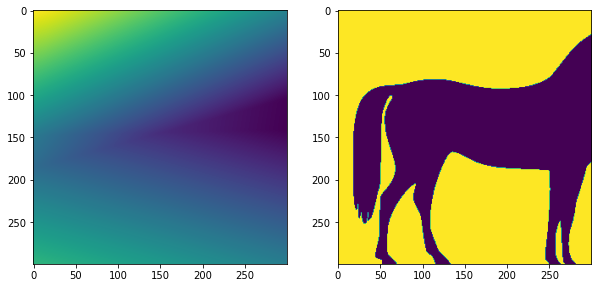

In [ ]:
plt.figure(figsize=(10, 20))
plt.subplot(1, 2, 1)
predicted = predicted.reshape(Image.shape)
plt.imshow(predicted)

plt.subplot(1, 2, 2)
Original = RGB_values.reshape(Image.shape)
plt.imshow(Original)

print(f"PSNR : {PSNR(Original, predicted)}")